In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
import tensorflow as tf 
tf.compat.v1.enable_eager_execution
from tensorflow import keras
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import numpy as np
print(tf.__version__)

2.2.0-dev20200303


In [0]:
try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf

     |████████████████████████████████| 516.0MB 28kB/s 
     |████████████████████████████████| 460kB 39.9MB/s 
     |████████████████████████████████| 2.8MB 37.4MB/s 
     |████████████████████████████████| 2.9MB 50.4MB/s 
     |████████████████████████████████| 778kB 45.0MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.


In [0]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    as_supervised=True,
    with_info=True)

In [0]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

In [0]:
encoder = info.features['text'].encoder
print('Vocabulary Size: {}'.format(encoder.vocab_size))

Vocabulary Size: 8185


In [0]:
#Text encoder
sample_string = 'I am the best'
encoded_string = encoder.encode(sample_string)
encoded_string

[12, 258, 1, 883]

In [0]:
for ts in encoded_string:
  print ('{} ----> {}'.format(ts, encoder.decode([ts])))

12 ----> I 
258 ----> am 
1 ----> the 
883 ----> best


In [0]:
for train_example, train_label in train_data.take(1):
  print('Encoded string:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

Encoded string: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0


In [0]:
#Encoder contains the decoder too
encoder.decode(train_example)

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

Padding is used to bring all sequences (are of different length) to zero pad.
Each batch has a shape of (batch_size, sequence_length). sequence_length will be different for each batch as padding is dynamic.

In [0]:
#Preparing the data for training
BUFFER_SIZE = 1000

train_batches = (train_data.shuffle(BUFFER_SIZE).padded_batch(32))

test_batches = (test_data.padded_batch(32))

In [0]:
for example_batch, label_batch in train_batches.take(2):
  print('Batch shape:', example_batch.shape)
  print('Label shape:', label_batch.shape)

Batch shape: (32, 1008)
Label shape: (32,)
Batch shape: (32, 1296)
Label shape: (32,)


In [0]:
#Building the model
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1)
])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [0]:
#Loss and optimizers
model.compile(
    optimizer = 'Adam', 
    loss = tf.losses.BinaryCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [0]:
#Model fit
history = model.fit(train_batches, epochs = 10, validation_data= test_batches, validation_steps=30)

Epoch 1/10
782/782 [==============================] - 7s 9ms/step - loss: 0.6148 - accuracy: 0.5602 - val_loss: 0.5923 - val_accuracy: 0.6292
Epoch 2/10
782/782 [==============================] - 8s 10ms/step - loss: 0.5368 - accuracy: 0.6710 - val_loss: 0.5296 - val_accuracy: 0.7333
Epoch 3/10
782/782 [==============================] - 8s 10ms/step - loss: 0.4717 - accuracy: 0.7538 - val_loss: 0.4820 - val_accuracy: 0.7240
Epoch 4/10
782/782 [==============================] - 8s 10ms/step - loss: 0.4203 - accuracy: 0.8042 - val_loss: 0.4426 - val_accuracy: 0.7937
Epoch 5/10
782/782 [==============================] - 8s 10ms/step - loss: 0.3794 - accuracy: 0.8341 - val_loss: 0.4171 - val_accuracy: 0.7937
Epoch 6/10
782/782 [==============================] - 8s 10ms/step - loss: 0.3475 - accuracy: 0.8546 - val_loss: 0.3955 - val_accuracy: 0.8417
Epoch 7/10
782/782 [==============================] - 8s 10ms/step - loss: 0.3221 - accuracy: 0.8686 - val_loss: 0.3811 - val_accuracy: 0.8500


In [0]:
#Evaluating our model
loss, accuracy = model.evaluate(test_batches)
print('Loss:', loss)
print('Accuracy:', accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3237 - accuracy: 0.8604
Loss: 0.3236579895019531
Accuracy: 0.8603600263595581


In [0]:
#The history object returned by model.fit contains details about what happened during training
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

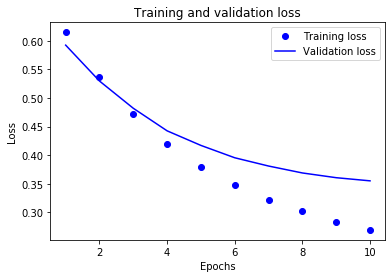

In [0]:
#Training and validation losses plots
import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(acc) + 1)
#'bo' is blue dot
plt.plot(epochs, loss, 'bo', label='Training loss')
#'b' is solid blue line
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

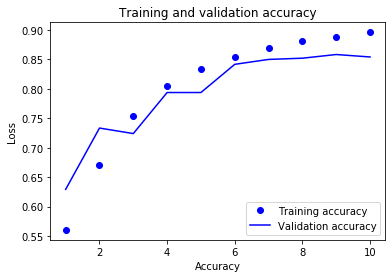

In [0]:
plt.plot(epochs, acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.legend(loc = 'lower right')
plt.show()

In [32]:
for test_ex, test_label in test_batches.take(1):
  answer = model.predict(test_ex)
  print(answer, test_label)

[[-1.066226  ]
 [ 3.3107316 ]
 [-3.020026  ]
 [-2.0458481 ]
 [ 2.0658014 ]
 [ 2.412808  ]
 [ 4.4921894 ]
 [ 5.878423  ]
 [ 1.0385308 ]
 [-1.1835165 ]
 [-8.317179  ]
 [-0.6638019 ]
 [ 0.90180194]
 [-0.54477316]
 [ 2.1947253 ]
 [-0.6315775 ]
 [ 1.9962146 ]
 [-1.7584485 ]
 [ 1.393167  ]
 [-5.3359857 ]
 [-3.7788432 ]
 [-1.8289045 ]
 [-1.546153  ]
 [-2.079473  ]
 [ 5.8288713 ]
 [-0.8683705 ]
 [-2.3190749 ]
 [-3.8204825 ]
 [-2.502239  ]
 [ 5.2014627 ]
 [ 2.021607  ]
 [ 3.3196833 ]] tf.Tensor([1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1], shape=(32,), dtype=int64)
